In [1]:
# %matplotlib inline
import numpy as np
import k3d
from k3d.colormaps import matplotlib_color_maps
import pathlib
import matplotlib.pyplot as plt
import imageio
import svox2
import torch
import tqdm

path = "./opt/ckpt/udf_lego_8/ckpt.npz"

grid = svox2.SparseGrid.load(path, device='cuda')
device = 'cuda'

/home/tw554/plenoxels/svox2/utils.py:39: UserWarning: CUDA extension svox2.csrc could not be loaded! Operations will be slow.
Please do not import svox in the svox2 source directory.
  warn("CUDA extension svox2.csrc could not be loaded! " +
/home/tw554/.conda/envs/voxel_sdf/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
def create_udf_surface(udfs, alphas, l, lv_sets, SURFACE_RANGE = 1.25, SAMPLE_NUM = 1e3):
    lx, ly, lz = l
    udf000, udf001, udf010, udf011, udf100, udf101, udf110, udf111 = \
        udfs

    alpha000, alpha001, alpha010, alpha011, alpha100, alpha101, alpha110, alpha111 = \
        alphas

    ys = torch.linspace(ly - SURFACE_RANGE, ly + 1 + SURFACE_RANGE, int(SAMPLE_NUM))
    zs = torch.linspace(lz - SURFACE_RANGE, lz + 1 + SURFACE_RANGE, int(SAMPLE_NUM))

    y_mesh, z_mesh = torch.meshgrid(ys,zs)
    yz = torch.vstack([y_mesh.flatten(), z_mesh.flatten()]).T

    pts = torch.zeros([int(SAMPLE_NUM**2), 3]).to(device)
    pts[:,1:] = yz

    wys, wzs = pts[:,1]-ly, pts[:,2]-lz
    c00 = udf000 * (1.-wzs) + udf001 * wzs
    c01 = udf010 * (1.-wzs) + udf011 * wzs
    c10 = udf100 * (1.-wzs) + udf101 * wzs
    c11 = udf110 * (1.-wzs) + udf111 * wzs
    c0 = c00 * (1.-wys) + c01 * wys
    c1 = c10 * (1.-wys) + c11 * wys
    # udf = c0 * (1.-wx) + c1 * wx = 0
    
    # find closest level set
    udf_avg = torch.mean(udfs)

    lv_dists = torch.abs(udf_avg - lv_sets)
    lv_set = lv_sets[lv_dists.min(axis=-1).indices]

    # print(f'level set is: {lv_set}')

    wxs =  (c0 -lv_set) / (c0 - c1)

    pts[:,0] = wxs.flatten() + lx


    # filter out points that are too far away
    min_dists = torch.min(torch.stack([torch.abs(pts[:, 0] - lx), torch.abs(pts[:, 0] - (lx+1))]), axis=0).values
    near_pt_ids = torch.arange(pts.shape[0])[(min_dists <= 2*SURFACE_RANGE) | ((lx <= pts[:, 0]) & (pts[:, 0] <= (lx+1)))]
    pts = pts[near_pt_ids,:]

    # filter out points with low alpha
    wa, wb = 1. - (pts - l), (pts - l)
        
    c00 = alpha000 * wa[:, 2:] + alpha001 * wb[:, 2:]
    c01 = alpha010 * wa[:, 2:] + alpha011 * wb[:, 2:]
    c10 = alpha100 * wa[:, 2:] + alpha101 * wb[:, 2:]
    c11 = alpha110 * wa[:, 2:] + alpha111 * wb[:, 2:]
    c0 = c00 * wa[:, 1:2] + c01 * wb[:, 1:2]
    c1 = c10 * wa[:, 1:2] + c11 * wb[:, 1:2]
    _alpha = c0 * wa[:, :1] + c1 * wb[:, :1]
    # post sigmoid activation
    _alpha = torch.sigmoid(_alpha)
    
    th = 0.01
    
    pts = pts[_alpha[:, 0] > th]
    _alpha = _alpha[_alpha[:, 0] > th]

    return pts, _alpha

with torch.no_grad():

    links = grid.links
    surface_data = grid.surface_data
    alpha_data = grid.density_data
    lv_sets = grid.level_sets

    ls = torch.stack(
        torch.meshgrid(torch.arange(links.shape[0]-1),torch.arange(links.shape[1]-1),torch.arange(links.shape[2]-1))
        ).reshape(3, -1).T.to(device)

    surface_pts = []
    surface_alphas = []

    render_ls = [ls[i] for i in range(ls.shape[0])]
    # render_ls = [[2,4,3], [2,5,3]]

    for l in tqdm.tqdm(render_ls):
        if (torch.tensor(l) < 0).any() or (torch.tensor(l).to(device) >= torch.tensor(links.shape).to(device) - 1).any():
            continue 
        lx, ly, lz = l
        links000 = links[lx, ly, lz]
        links001 = links[lx, ly, lz + 1]
        links010 = links[lx, ly + 1, lz]
        links011 = links[lx, ly + 1, lz + 1]
        links100 = links[lx + 1, ly, lz]
        links101 = links[lx + 1, ly, lz + 1]
        links110 = links[lx + 1, ly + 1, lz]
        links111 = links[lx + 1, ly + 1, lz + 1]

        surfaces = torch.tensor([surface_data[links000,0], surface_data[links001,0], surface_data[links010,0], surface_data[links011,0], surface_data[links100,0], surface_data[links101,0], surface_data[links110,0], surface_data[links111,0]]).to(device)
        alphas = torch.tensor([alpha_data[links000,0], alpha_data[links001,0], alpha_data[links010,0], alpha_data[links011,0], alpha_data[links100,0], alpha_data[links101,0], alpha_data[links110,0], alpha_data[links111,0]]).to(device)

    #     print(f'udf Raw: {surfaces}')

        pts, pt_alphas = create_udf_surface(surfaces, alphas, l, lv_sets, SURFACE_RANGE=0, SAMPLE_NUM=100)

        surface_pts.append(pts)
        surface_alphas.append(pt_alphas)

    pts = torch.cat(surface_pts).cpu().detach().numpy()
    surface_alphas = torch.cat(surface_alphas).cpu().detach().numpy()


  0%|                                                                                                                         | 0/343 [00:00<?, ?it/s]/tmp/ipykernel_2191493/1436991122.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if (torch.tensor(l) < 0).any() or (torch.tensor(l).to(device) >= torch.tensor(links.shape).to(device) - 1).any():
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [00:04<00:00, 78.13it/s]


In [8]:
plt_points = k3d.points(positions=pts,
                        point_size=0.02,
                        shader='3d',
#                         opacities=surface_alphas,
                        color_map=matplotlib_color_maps.Coolwarm,
                        attribute=surface_alphas,
#                         color=0x3f6bc5,
                       )

plot = k3d.plot()
plot += plt_points
plot.display()

Output()

In [26]:
pts.shape

(63062441, 3)

In [13]:
surface_alphas

array([[0.00102483],
       [0.00180971],
       [0.0016351 ],
       ...,
       [0.00176069],
       [0.00130266],
       [0.00126886]], dtype=float32)

/tmp/ipykernel_2089852/1268264342.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path)


<IPython.core.display.Javascript object>


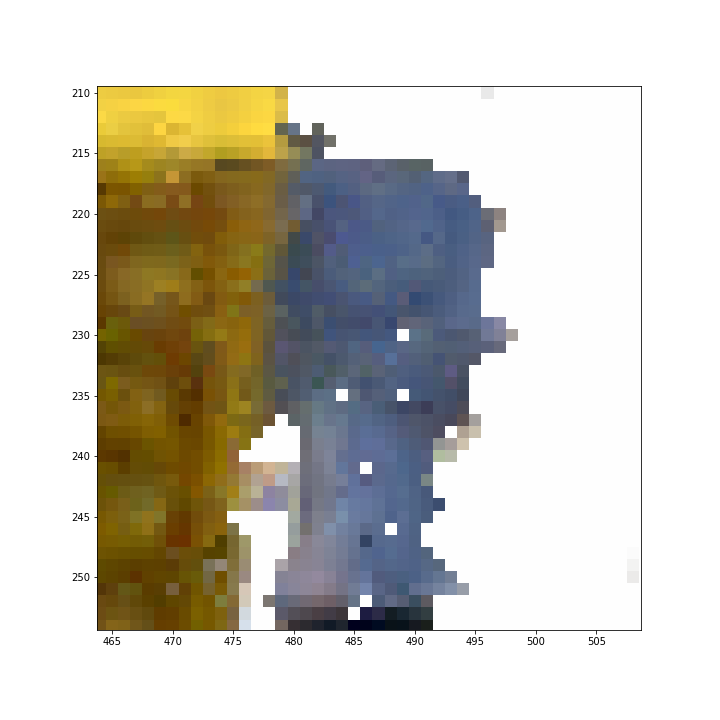

In [3]:
%matplotlib notebook

path = '/home/tw554/plenoxels/imgs/individualImage.png'
img = imageio.imread(path)

plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(img)
plt.show()

<IPython.core.display.Javascript object>


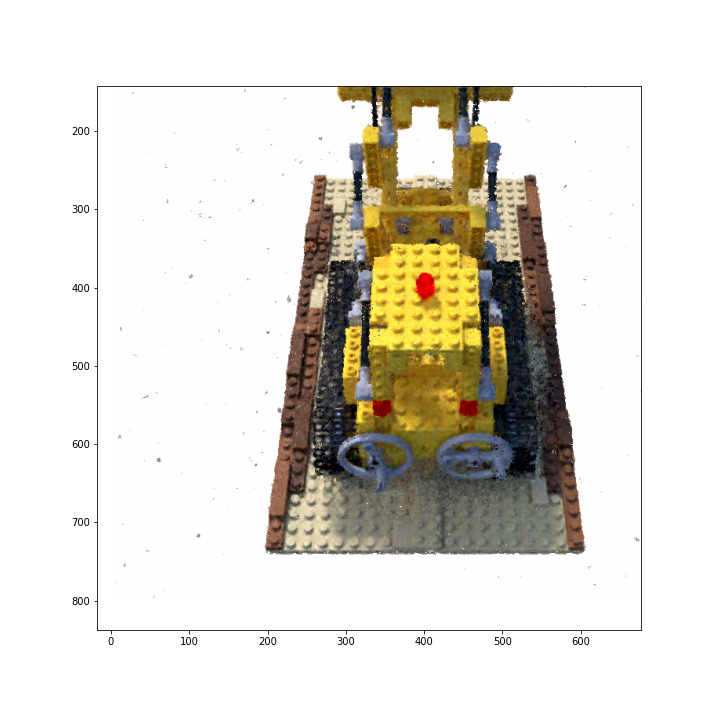

In [8]:
y, x = [489, 235]
img[x, y] = [255, 0, 0]

%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(img)
plt.show()